# 0 - Test for GPU
Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats

import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Wed Jan 26 12:57:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Explore and preprocess the data
## 1.1 - Download and plot the data
We'll start by downloading our data set contained in a zip archive. Execute the code below for downloading and extracting the data to /tmp/bee-vs-wasp.zip.

In [2]:
#@title Dataset Download and Preprocessing

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

dataset_file = '/tmp/kaggle_bee_vs_wasp.zip'
download_file_from_google_drive('1-aqpfT73D7HCQGoQEFg-phd3Mtsb9PiP',dataset_file)
unzip('/tmp/kaggle_bee_vs_wasp.zip')

The base directory `/tmp/bee-vs-wasp` contains the subdirectories. Let's define the base directory:

In [3]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

base_dir = '/tmp/kaggle_bee_vs_wasp/'
output_dir = '/tmp/output/'

Get the `labels.csv` of the data set:

In [4]:
df = pd.read_csv(base_dir+'/labels.csv')
df = df.set_index('id')

# You can perform dataset subsampling by adding frac=training_subsample as argument to the sample function, 
# with training_subsample within [0,1].
# For development, you should use a small fraction of the entire dataset rater than full dataset, e.g. 0.1.
# For now lets use the whole Dataset
training_subsample = 1 
df = df.sample(frac=training_subsample,axis=0)


# Replace \\ in path with / to load images properly
for index in tqdm(df.index):    
    df.loc[index,'path']=df.loc[index,'path'].replace('\\', '/') 
df['path'] = base_dir + df['path']

100%|██████████| 11420/11420 [00:07<00:00, 1511.27it/s]



Now we can create the training, validation and test data set by filtering the dataframe:

In [5]:
# Firstly, we create our training set from the data frame
train_df = df.query("(is_validation==0) and (is_final_validation==0)")
train_classes = train_df["label"]

# Now we can do the same for the valdation set
validation_df = df.query("(is_validation==1) and (is_final_validation==0)")
validation_classes = validation_df["label"]

# Now we can do the same for the test set
test_df = df.query("(is_validation==0) and (is_final_validation==1)")

Now we create our data set generators as learned in the lecture:

In [6]:
#@title Prepare data generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

num_classes = 4

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_dataframe(
                    validation_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False)

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_dataframe(
                    test_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    class_mode='categorical',
                    shuffle=False)

train_steps = np.ceil(train_generator.samples / train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

print(train_steps)
print(val_steps)

Found 7938 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.
125.0
27.0


We now build and train the model. For now lets use a fresh `EfficientNetB0` model trained from scratch:

In [7]:
#@title Build the EfficientNetB0 model

from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes, lr ,summary=True):

  model = EfficientNetB0(include_top=True, weights=None, input_shape=input_shape,classes=num_classes)
  model.compile(
      optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
  )
  
  if summary:
    print(model.summary())

  return model



Now we define our initial learning rate for the training and define our model:

In [8]:
#@title Build the model

INITIAL_LEARNING_RATE = 1e-3
model = build_model((224,224,3), num_classes, INITIAL_LEARNING_RATE)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


----------------------------------------- THIS SECTION IS FOR TRAINING THE EFFICIENTNET (SKIP IF YOU ALREADY TRAINED WEIGHTS) ------------------------------

In this section we train our network with the methods learned in the lecture:

In [9]:
#@title Plot the training history

from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

In [10]:
#@title LRD and early stopping

def lr_step_decay(epoch, lr, drop=.9, drop_epochs=10):
  if epoch < 10:
    return INITIAL_LEARNING_RATE
  else:
    return INITIAL_LEARNING_RATE * np.power(drop, np.floor(epoch/drop_epochs))

LRDecayCallback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)
StopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
125/125 - 124s - loss: 2.1108 - accuracy: 0.4291 - val_loss: 1.5303 - val_accuracy: 0.4363 - lr: 0.0010 - 124s/epoch - 994ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
125/125 - 115s - loss: 1.4216 - accuracy: 0.5378 - val_loss: 1.3875 - val_accuracy: 0.4363 - lr: 0.0010 - 115s/epoch - 921ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/200
125/125 - 116s - loss: 1.1215 - accuracy: 0.5863 - val_loss: 2.0294 - val_accuracy: 0.4363 - lr: 0.0010 - 116s/epoch - 926ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/200
125/125 - 115s - loss: 1.0152 - accuracy: 0.6255 - val_loss: 1.7342 - val_accuracy: 0.2077 - lr: 0.0010 - 115s/epoch - 916ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/200
125/125 - 115s - loss: 0.9351 - accuracy: 0.6475 - val_loss: 1.4262 - val_accura

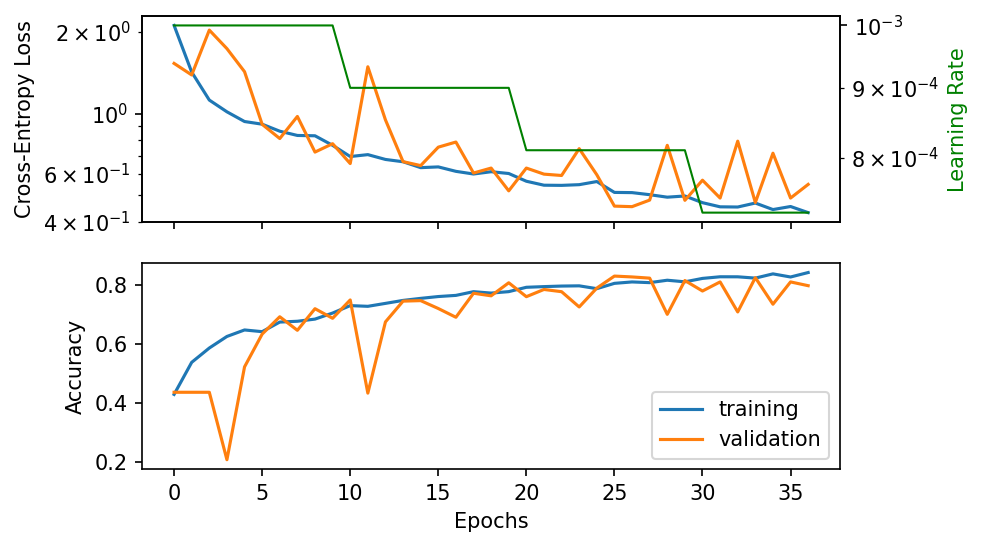

In [ ]:
#@title Train the model

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=200,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[LRDecayCallback,StopCallback],
                    verbose=2)

plot_history( history )

The learned weights should be saved so we can use them again:

In [ ]:
#@title Save the weights

from google.colab import drive
drive.mount('/content/gdrive')
name_of_trained_weights = 'efficientnet_weights_full'
model.save_weights('/tmp/'+ name_of_trained_weights)

%cp /tmp/efficientnet_weights_full.data-00000-of-00001 /content/gdrive/My\ Drive
%cp /tmp/efficientnet_weights_full.index /content/gdrive/My\ Drive

Mounted at /content/gdrive


---------------------------------------------- END OF TRAINING SECTION ----------------------------------------------------

# 2 - Training results

Here you can load already trained weights to the defined model:

In [12]:
#@title Load the trained weights

from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/gdrive/My\ Drive/efficientnet_weights_full.data-00000-of-00001 /tmp/
%cp /content/gdrive/My\ Drive/efficientnet_weights_full.index /tmp/
model.load_weights("/tmp/efficientnet_weights_full")

Mounted at /content/gdrive


Now lets take a look at the results:

In [13]:
#@title Print training results and predictions

# We output the test accuracy and loss
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Use the model to predict on the 1763 images of the test generator
pred = model.predict_generator(test_generator,  1763)

# And get their according labels
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_generator.class_indices)

# Swap indices with label for comparison
labels2=dict((v,k) for k,v in labels.items())

# Output the label as human readable prediction 
predictions=[labels2[k] for k in predicted_class_indices]

print(predicted_class_indices)
print(labels)
print(predictions)

56/56 [==============================] - 19s 140ms/step - loss: 0.4466 - accuracy: 0.8344
test loss, test acc: [0.44655048847198486, 0.8343732357025146]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


[2 3 0 ... 3 1 3]
{'bee': 0, 'insect': 1, 'other': 2, 'wasp': 3}
['other', 'wasp', 'bee', 'insect', 'wasp', 'wasp', 'wasp', 'wasp', 'insect', 'wasp', 'bee', 'bee', 'wasp', 'bee', 'insect', 'insect', 'bee', 'wasp', 'bee', 'wasp', 'wasp', 'wasp', 'insect', 'bee', 'wasp', 'wasp', 'insect', 'wasp', 'wasp', 'bee', 'bee', 'wasp', 'wasp', 'wasp', 'wasp', 'wasp', 'insect', 'wasp', 'insect', 'bee', 'wasp', 'insect', 'wasp', 'insect', 'insect', 'insect', 'wasp', 'insect', 'bee', 'wasp', 'bee', 'insect', 'bee', 'wasp', 'wasp', 'bee', 'wasp', 'bee', 'insect', 'insect', 'wasp', 'bee', 'bee', 'bee', 'bee', 'wasp', 'wasp', 'insect', 'insect', 'wasp', 'insect', 'wasp', 'wasp', 'bee', 'wasp', 'bee', 'wasp', 'bee', 'bee', 'insect', 'wasp', 'insect', 'insect', 'insect', 'wasp', 'insect', 'bee', 'insect', 'insect', 'insect', 'wasp', 'bee', 'insect', 'wasp', 'wasp', 'wasp', 'wasp', 'other', 'wasp', 'wasp', 'insect', 'insect', 'bee', 'wasp', 'bee', 'bee', 'insect', 'bee', 'bee', 'wasp', 'bee', 'insect', 'wa

Now we can print a confusion matrix to see how big the error of our trained model is:

In [14]:
#@title Confusion matrix

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_df["label"],predictions))

[[441  29   5  29]
 [ 34 302   8  32]
 [  0   1 109  20]
 [ 56  59  19 619]]


Now that we have some metrics lets test our predictions on some images:

In [15]:
#@title Plot results

def displayImagesLabelsAndPredictions(array_of_idx):
  plt.figure(figsize=(15,10))
  pos = 1
  idx = 0
  for row in np.array(test_df['path'])[array_of_idx]:
    img = cv2.imread(row)

    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title("label: "+str((np.array(test_df["label"])[array_of_idx][idx])+"\n prediction: "+str(np.array(predictions)[array_of_idx][idx])))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    #Remove ticks
    plt.xticks([])
    plt.yticks([])
    pos+=1
    idx+=1
  plt.show()

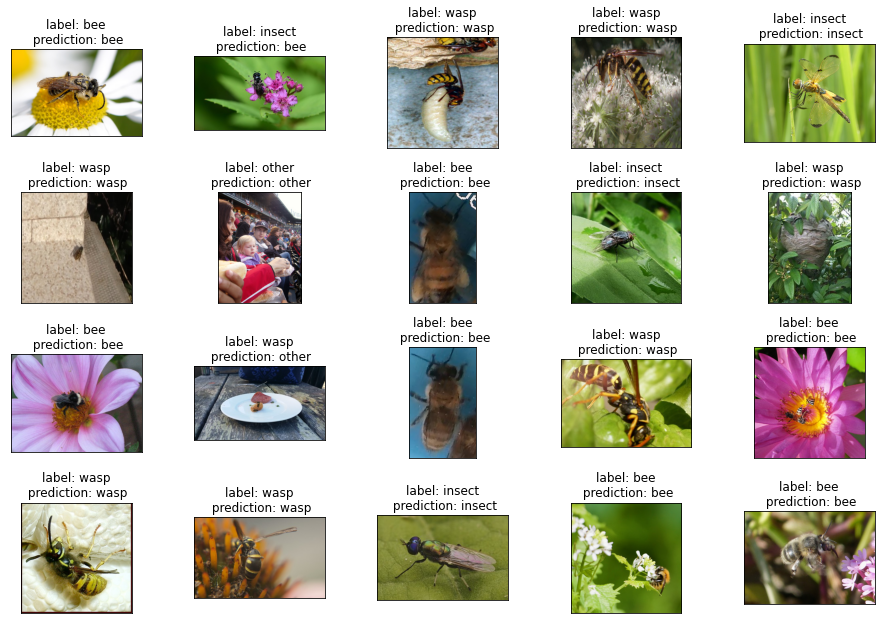

In [17]:
import random
img_count=20
random_images = random.sample(range(1763), img_count)
displayImagesLabelsAndPredictions(random_images)